# Capstone project 

#### Objectives/ Problem Statement
To predict the price of new HDB launch before the launch 

#### why this problem?
A practical problem that most Singaporeans (including myself) face 

## Part3_ TimeSeriesAnalysis

**[Iteration 1: Using all resale data](#iter1)** <br> 
[Time series EDA](#1eda)  ||  [ARIMA](#1arima)<br> 

**[Iteration 2: using LSTM](#iter2)** <br>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA, ARIMA

from sklearn.metrics import r2_score

### Quick Cleaning 
(code and analysis taken from Part2_EDA)

In [3]:
resale = pd.read_csv('./datasets/resale_all.csv')
resale.drop([u'Unnamed: 0',u'geo_data',u'full_address','new full_address'],axis = 1,inplace=True)

#time
resale['date'] = pd.to_datetime(resale['month'])
resale['year'] = resale['date'].apply(lambda x:x.year)
resale['month'] = resale['date'].apply(lambda x:x.month)

C:\Users\ngyen\Anaconda2python2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Taking into consideration inflation across the years, we adjust the resale_price accordingly 
# inflation_rate is obtained from MAS website

inflation = pd.read_csv('./datasets/inflation_rate.csv')
inflation['value_of_1000_today'] = inflation['value_of_1000_today'].astype(int)/1000
inflate = inflation[['Year','value_of_1000_today']].values.tolist()

resale['adj_price'] = [price*change for p_year,price in zip(resale['year'],resale['resale_price']) 
                                        for [year,change] in inflate 
                                        if p_year == year]

<a id='iter1'></a>
## Iteration1: Using all resale data 

In [5]:
price_time = resale.groupby(['date']).mean()[['resale_price','adj_price']]
price_time.columns = ['mean_resale_price','mean_adj_price']
#obtain price difference
price_time['pdiff'] = price_time['mean_resale_price'].diff()
price_time['adj_pdiff'] = price_time['mean_adj_price'].diff()
price_time = pd.DataFrame(price_time.resample('M').sum())
price_time['year'] = price_time.index.year
price_time.replace(0.00,np.nan,inplace=True)
print(price_time.shape)
price_time.head()

(341, 5)


,mean_resale_price,mean_adj_price,pdiff,adj_pdiff,year
date,,,,,
1990-01-31,64911.755424,109765.778422,NaN,NaN,1990
1990-02-28,67657.745726,114409.248024,2745.990302,4643.469601,1990
1990-03-31,66513.820624,112474.870675,-1143.925103,-1934.377348,1990
1990-04-30,65649.574669,111013.430766,-864.245955,-1461.439909,1990
1990-05-31,67621.865140,114348.573952,1972.290471,3335.143186,1990


<a id='1eda'></a>
### EDA

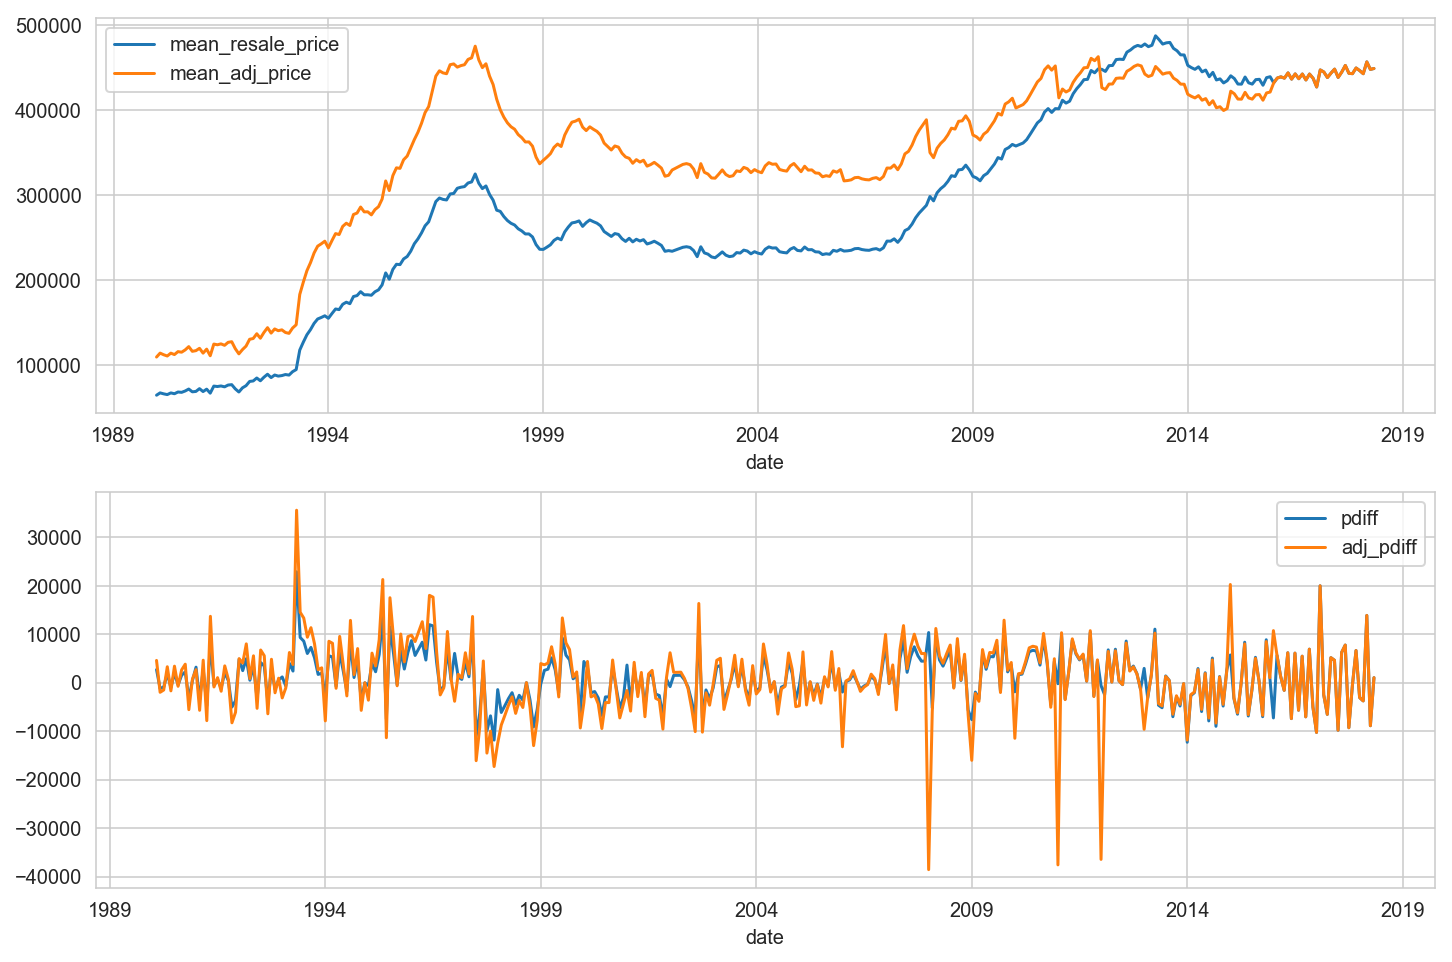

In [6]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,8))
price_time[[col for col in price_time if 'mean' in col]].plot(ax=ax[0])
price_time[[col for col in price_time if 'mean' not in col]].drop('year',axis=1).plot(ax=ax[1]);

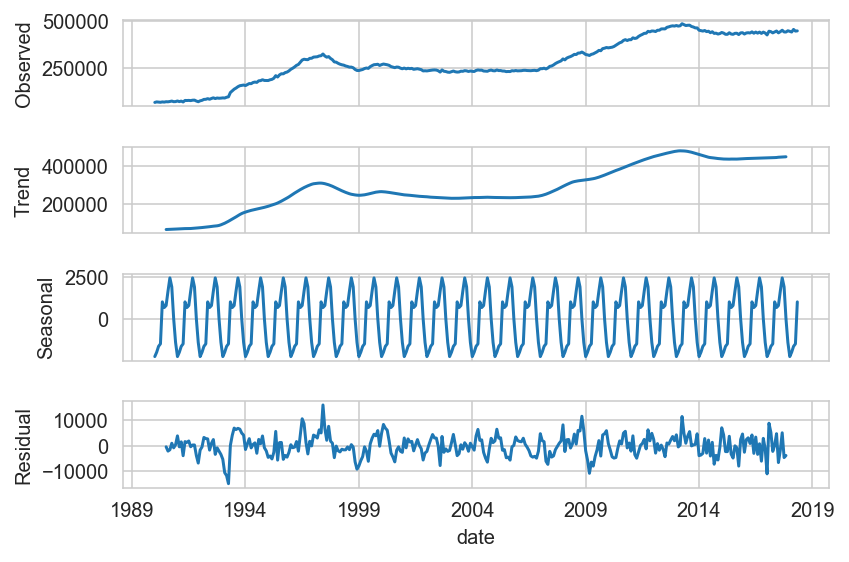

In [7]:
result = seasonal_decompose(price_time['mean_resale_price'])
result.plot();

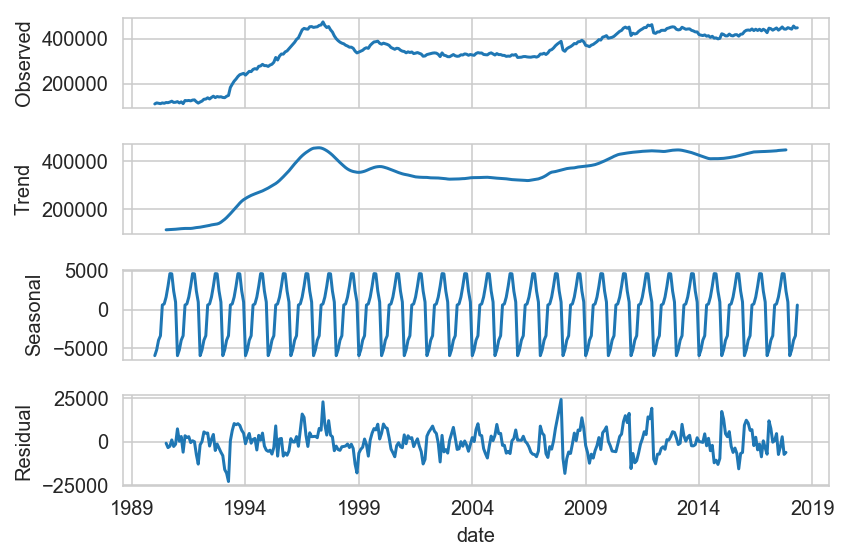

In [8]:
result = seasonal_decompose(price_time['mean_adj_price'])
result.plot();

In [9]:
def show_autocorrelation(df,col):
    fig, ax = plt.subplots(nrows = 2, ncols =1, figsize=(8,5))
    plot_acf(df[col], lags=30, ax=ax[0])
    plot_pacf(df[col], lags=30, ax=ax[1])
    plt.suptitle('Autocorrelation for '+col,fontsize = 16)
    plt.show()
    
# Define a Dickey-Fuller test.

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(8, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput )


#### Looking at mean_resale_price

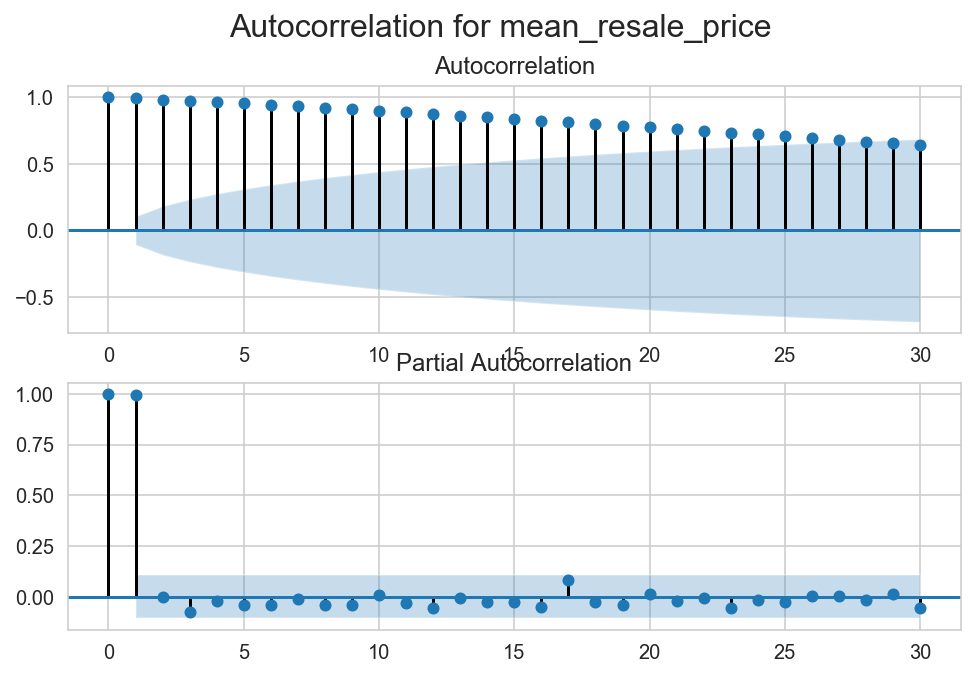

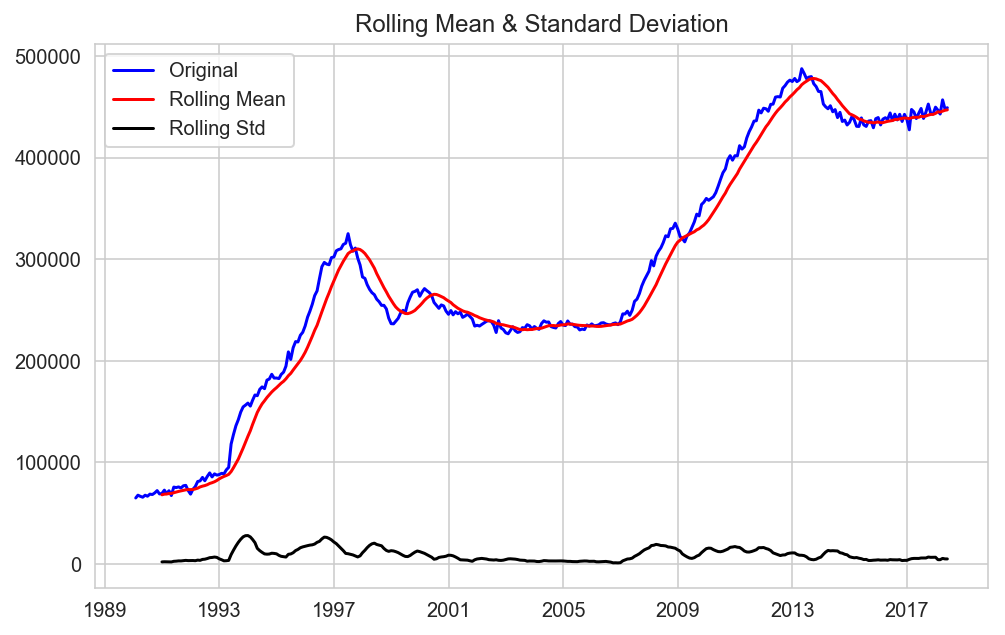

Results of Dickey-Fuller Test:
Test Statistic                  -1.373372
p-value                          0.594973
#Lags Used                      17.000000
Number of Observations Used    323.000000
Critical Value (1%)             -3.450759
Critical Value (5%)             -2.870530
Critical Value (10%)            -2.571560
dtype: float64


In [10]:
show_autocorrelation(price_time,'mean_resale_price')
test_stationarity(price_time['mean_resale_price'])

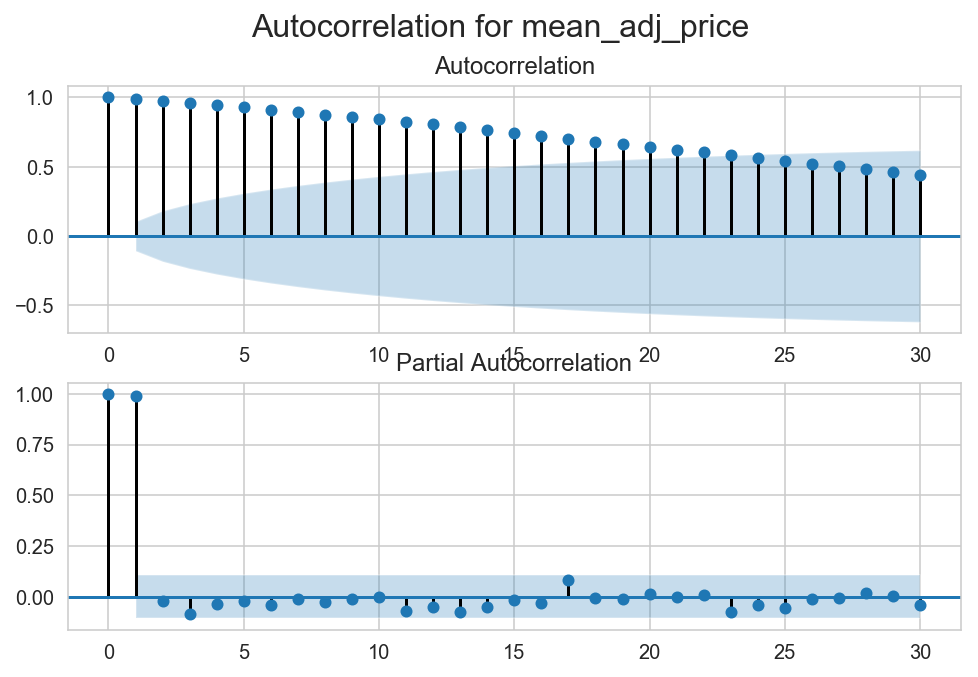

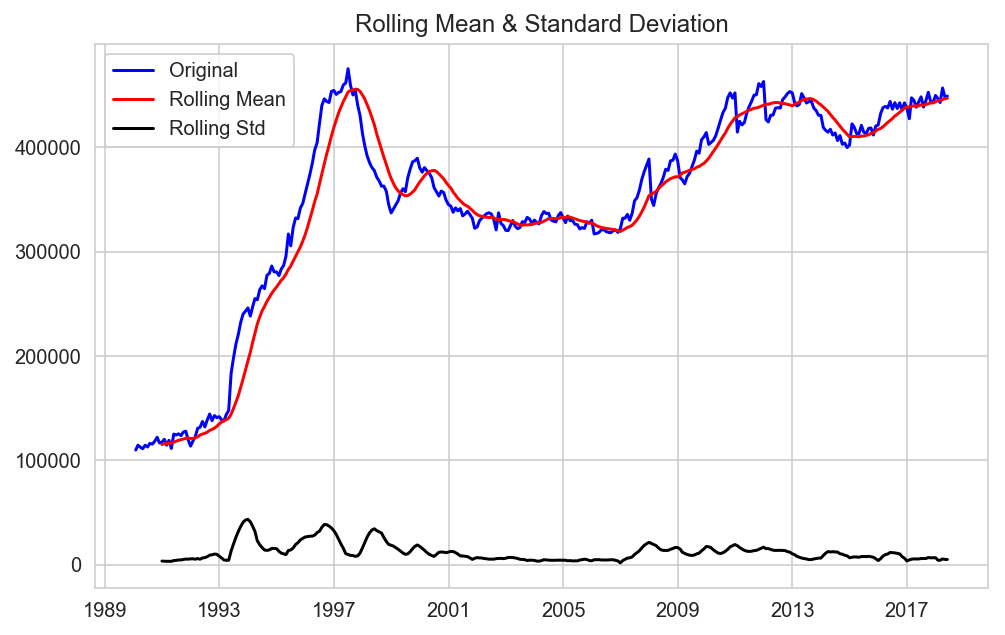

Results of Dickey-Fuller Test:
Test Statistic                  -2.483129
p-value                          0.119633
#Lags Used                      17.000000
Number of Observations Used    323.000000
Critical Value (1%)             -3.450759
Critical Value (5%)             -2.870530
Critical Value (10%)            -2.571560
dtype: float64


In [11]:
show_autocorrelation(price_time,'mean_adj_price')
test_stationarity(price_time['mean_adj_price'])

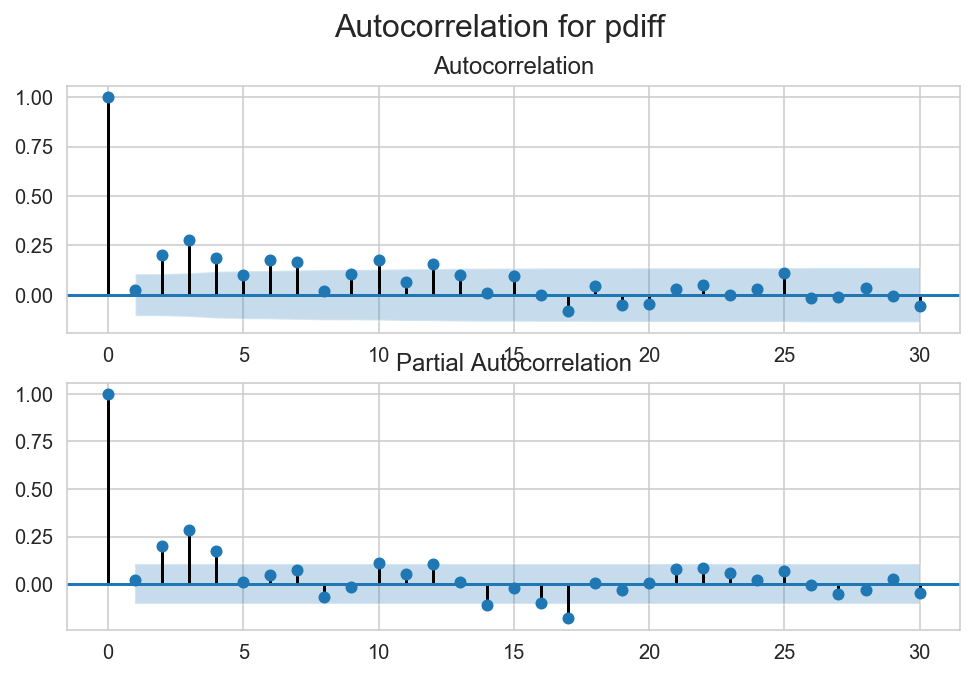

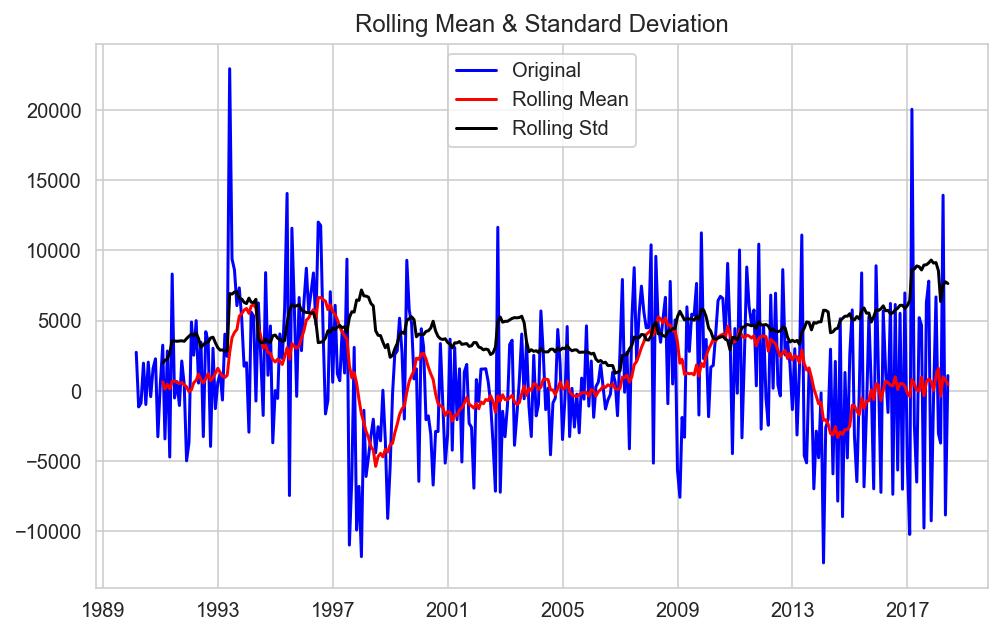

Results of Dickey-Fuller Test:
Test Statistic                  -4.065853
p-value                          0.001102
#Lags Used                      16.000000
Number of Observations Used    323.000000
Critical Value (1%)             -3.450759
Critical Value (5%)             -2.870530
Critical Value (10%)            -2.571560
dtype: float64


In [12]:
show_autocorrelation(price_time.dropna(),'pdiff')
test_stationarity(price_time['pdiff'].dropna())

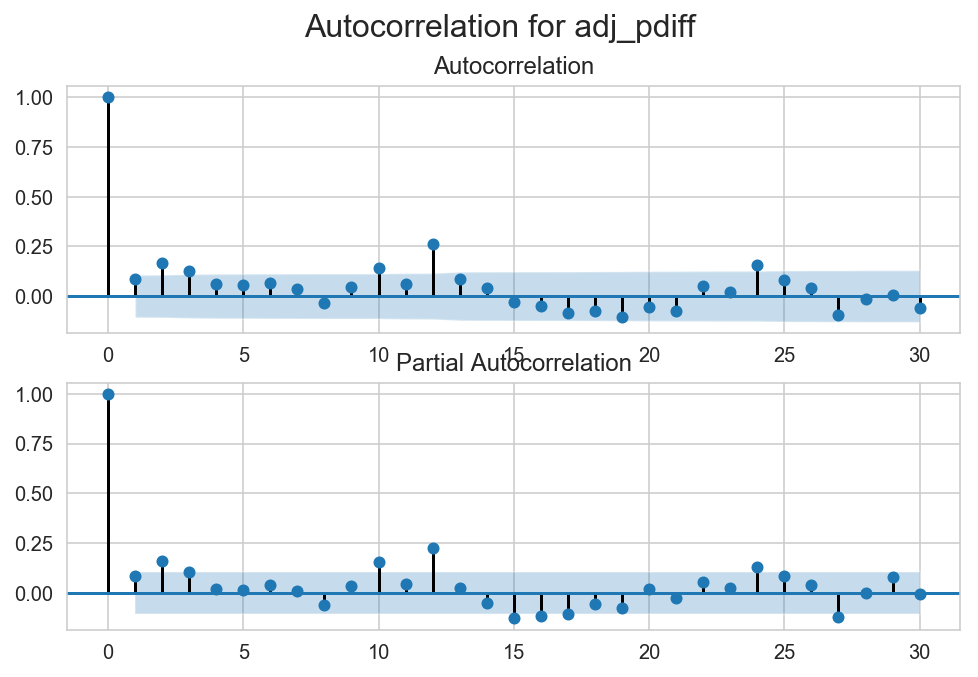

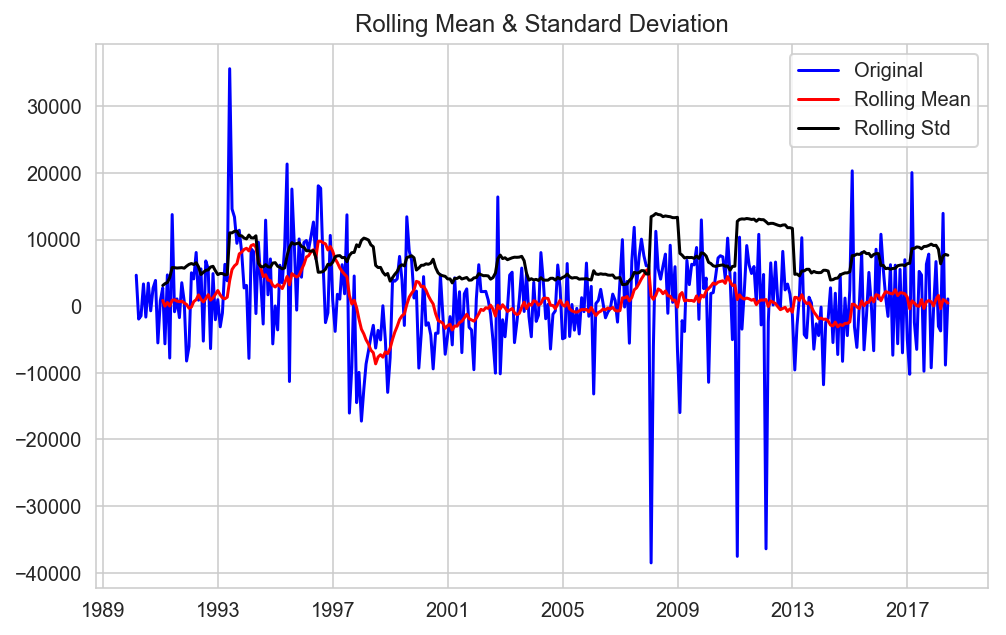

Results of Dickey-Fuller Test:
Test Statistic                  -4.023552
p-value                          0.001292
#Lags Used                      16.000000
Number of Observations Used    323.000000
Critical Value (1%)             -3.450759
Critical Value (5%)             -2.870530
Critical Value (10%)            -2.571560
dtype: float64


In [13]:
show_autocorrelation(price_time.dropna(),'adj_pdiff')
test_stationarity(price_time['adj_pdiff'].dropna())

In [14]:
train = price_time[price_time['year']<2014]
test =  price_time[price_time['year']>=2014]

In [15]:
print(price_time.shape)
print(train.shape)
print(test.shape)
print(len(train) + len(test))
print(float(len(test))/len(price_time))

(341, 5)
(288, 5)
(53, 5)
341
0.15542521994134897


<a id='1arima'></a>
### Iteration1: ARIMA

In [16]:
def Analyse_TS_Model(model,df,train,test,col):
    predictions = model.predict()
    full_pred = train[col].values[0]+np.cumsum(model.fittedvalues)
    
    #Graph
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(train.index[1:], full_pred, lw=2, color='grey', ls='dashed',label = 'in-sample prediction')
    ax.plot(df.index, df['mean_resale_price'], lw=2, color='darkred')
    ax.plot(test.index, model.forecast(steps=len(test))[0], lw=2, color='blue',label = 'forecast')
    ax.plot(test.index, model.forecast(steps=len(test))[2], lw=2, color='blue', ls='dashed',label = 'forecast')
    

In [17]:
def TS_Score(model,train,test,col):
    aic = model.aic
    bic = model.bic 
    train_r2 = r2_score(train[col][1:], train[col].values[0]+np.cumsum(model.fittedvalues))
    test_r2 = r2_score(test[col], model.forecast(steps=len(test))[0])
    pval = str(model.pvalues)
    pval_boolean = all(model.pvalues < 0.05 )
    model_name = ' '.join([item[:5] for item in model.params.index if item !='const'])
    return {'model': model_name,
            'aic' : aic, 
            'bic': bic, 
            'train_r2': train_r2, 
            'test_r2': test_r2, 
            'pval_boolean': pval_boolean,
            'pval' : pval}


#WIP
def Add_model(model,train,test,col,df):
    score = TS_Score(model,train,test,col)    
    
    if type(df) == list:
        row = pd.DataFrame(score, index = [0])
        df = pd.DataFrame(columns=['model', 'aic', 'bic', 'train_r2', 'test_r2', 'pval_boolean', 'pval'])
        new_df = pd.concat([df,row])
    else:
        row_num = len(df)
        row = pd.DataFrame(score, index = [row_num])
        new_df = pd.concat([df,row])
        
    return new_df

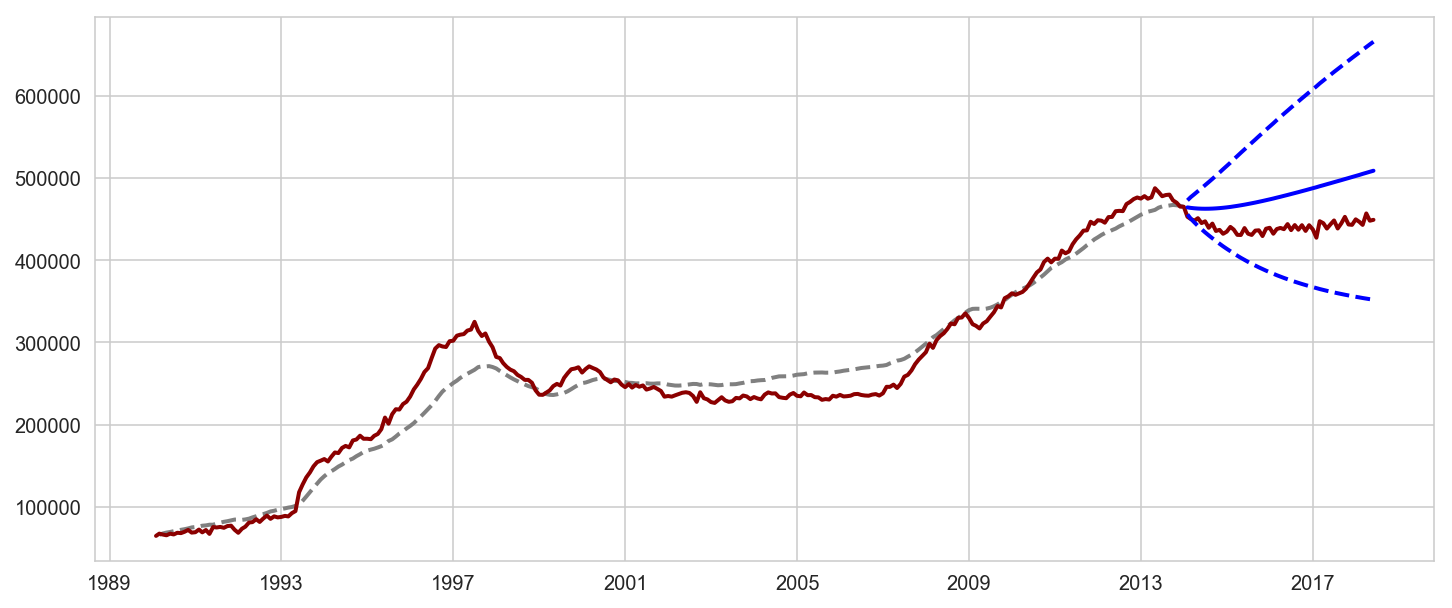

In [18]:
model = ARIMA(train['mean_resale_price'], (1, 1, 1)).fit()
Analyse_TS_Model(model,price_time,train,test,'mean_resale_price')
summary = Add_model(model,train,test,'mean_resale_price',[])

C:\Users\ngyen\Anaconda2python2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\ngyen\Anaconda2python2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\ngyen\Anaconda2python2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`

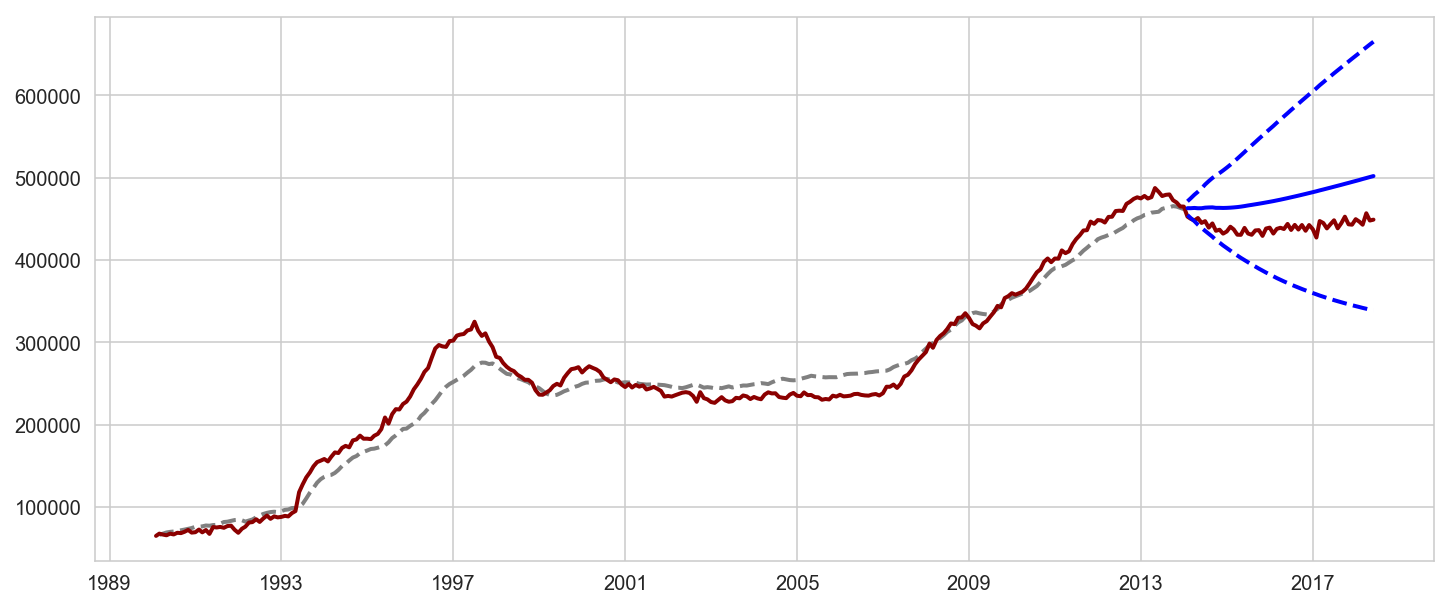

In [19]:
model = ARIMA(train['mean_resale_price'], (12, 1, 0)).fit()
Analyse_TS_Model(model,price_time,train,test,'mean_resale_price')
summary = Add_model(model,train,test,'mean_resale_price',summary)

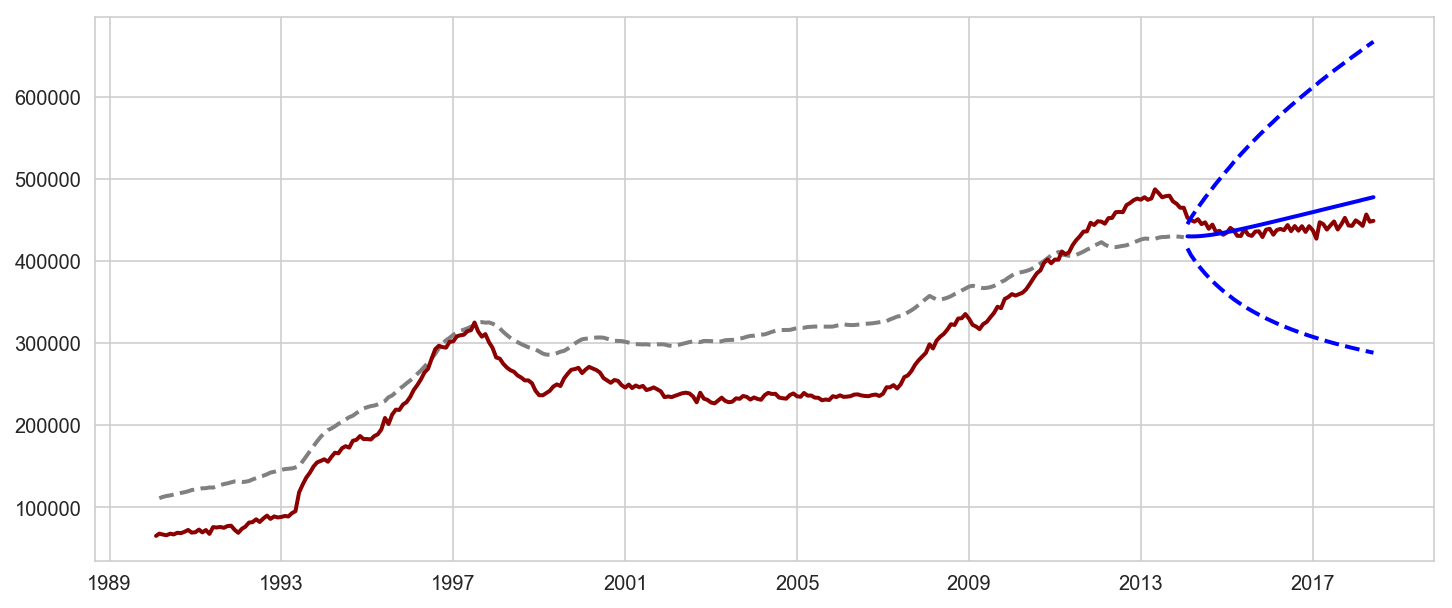

In [20]:
model = ARIMA(train['mean_adj_price'], (1, 1, 1)).fit()
Analyse_TS_Model(model,price_time,train,test,'mean_adj_price')
summary = Add_model(model,train,test,'mean_adj_price',summary)

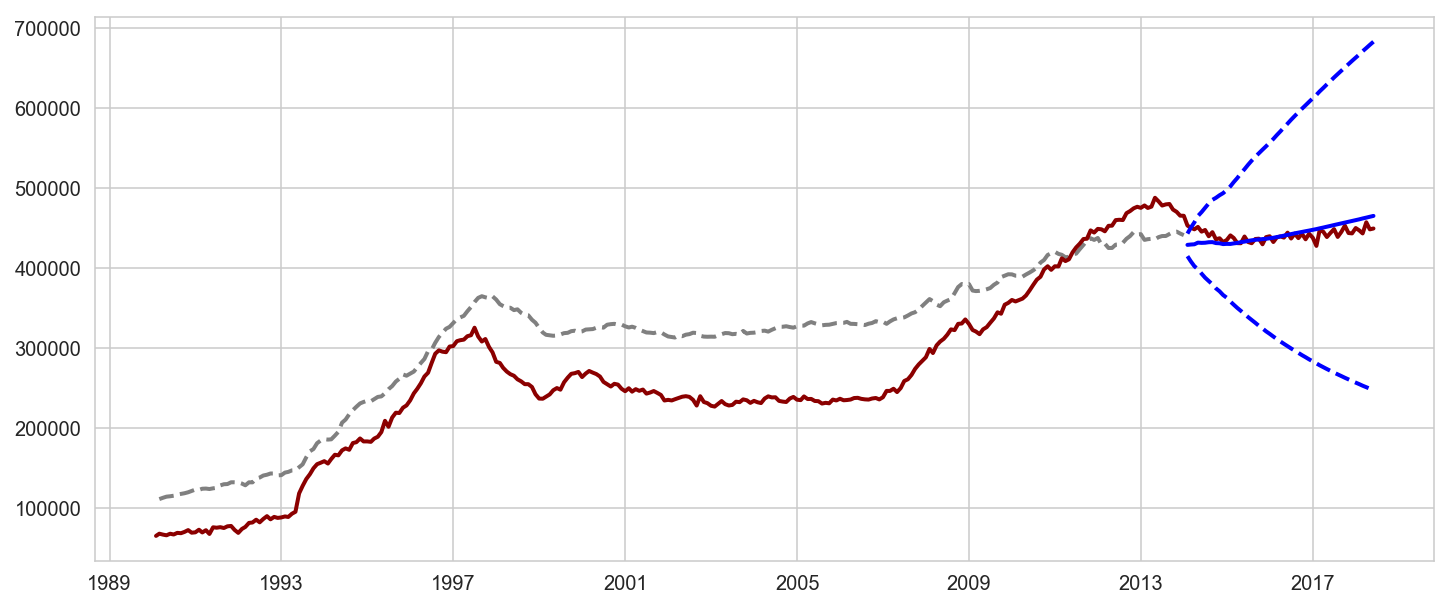

In [21]:
model = ARIMA(train['mean_adj_price'], (12, 1, 1)).fit()
Analyse_TS_Model(model,price_time,train,test,'mean_adj_price')
summary = Add_model(model,train,test,'mean_adj_price',summary)

In [22]:
summary

,model,aic,bic,train_r2,test_r2,pval_boolean,pval
0,ar.L1 ma.L1,5635.207453,5649.845382,0.958524,-37.423260,False,const 7.444725e-02\nar....
1,ar.L1 ar.L2 ar.L3 ar.L4 ar.L5 ar.L6 ar.L7 ar.L...,5639.068593,5690.301344,0.962712,-30.579780,False,const 0.112802\nar.L1....
2,ar.L1 ma.L1,5949.068365,5963.706294,0.703683,-1.102199,False,const 1.916023e-01\nar.L1....
3,ar.L1 ar.L2 ar.L3 ar.L4 ar.L5 ar.L6 ar.L7 ar.L...,5943.774609,5998.666842,0.823998,0.068150,False,const 0.285795\nar.L1.D.m...


<a id='iter2'></a>
## Neural networks: LSTM 

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [24]:
def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[:-1, :]
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [25]:
def lstm_prediction_plotter(model,trainX,testX,orig_data):
    model.reset_states()
    trainPredict = model.predict(trainX)
    model.reset_states()
    testPredict = model.predict(testX)
    model.reset_states()

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(orig_data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(orig_data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[-len(testPredict)-1:-1, :] = testPredict


    fig, ax = plt.subplots(ncols=1, nrows =2, figsize = (12,8))

    ax[0].plot(orig_data,label='original data')
    ax[0].plot(trainPredictPlot,label='in_sample prediction')
    ax[0].plot(testPredictPlot,label='out_sample prediction')
    ax[1].set_title('Graph of all data')
    ax[0].set_xticks([])
    ax[0].legend()

    ax[1].plot(orig_data[250:],label='original data')
    ax[1].plot(trainPredictPlot[250:],label='in_sample prediction')
    ax[1].plot(testPredictPlot[250:],label='out_sample prediction')
    ax[1].set_title('Zoom in to tested portion')
    ax[1].set_xticks([])
    ax[1].legend()
    plt.suptitle('Graph of prediction vs actual data', fontsize = 16);

In [26]:
def lstm_obtain_r2(model,trainX,testX,trainY,testY):
    model.reset_states()
    trainPredict = model.predict(trainX)
    model.reset_states()
    testPredict = model.predict(testX)
    model.reset_states()
    
    train_r2 = r2_score(trainY, trainPredict)
    print('train_r2',train_r2) 
    test_r2 = r2_score(testY[:-1], testPredict[1:])
    print('test_r2',test_r2)
    return [train_r2,test_r2]

In [27]:
def add_lstm_score(col,model_name,results,df):
    row = pd.DataFrame([col,model_name] + results, index=['col','model','train_r2_score','test_r2_score']).T
    
    if type(df) == list:
        df = pd.DataFrame(columns=['col','model','train_r2_score','test_r2_score'])
        new_df = pd.concat([df,row])
    else:
        new_df = pd.concat([df,row])
        
    return new_df

In [28]:
mms = MinMaxScaler(feature_range=(-1, 1))
col = 'mean_resale_price'
mean_resale_px = price_time[[col]]
mean_resale_px = mms.fit_transform(mean_resale_px)

In [29]:
train_size = len(train)
test_size = len(mean_resale_px) - train_size
print(len(mean_resale_px), train_size, test_size)

train, test = mean_resale_px[0:train_size,:], mean_resale_px[train_size:len(mean_resale_px),:]

341 288 53


In [30]:
lag = 1
trainX, trainY = create_data(train, lag)
testX, testY = create_data(test, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Epoch 1/20
287/287 [==============================] - 2s 6ms/step - loss: 0.2892
Epoch 2/20
287/287 [==============================] - 1s 3ms/step - loss: 0.2186
Epoch 3/20
287/287 [==============================] - 1s 2ms/step - loss: 0.1288
Epoch 4/20
287/287 [==============================] - 1s 3ms/step - loss: 0.0523
Epoch 5/20
287/287 [==============================] - 1s 3ms/step - loss: 0.0153
Epoch 6/20
287/287 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 7/20
287/287 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 8/20
287/287 [==============================] - 1s 2ms/step - loss: 0.0047
Epoch 9/20
287/287 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 10/20
287/287 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 11/20
287/287 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 12/20
287/287 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 13/20
287/287 [====

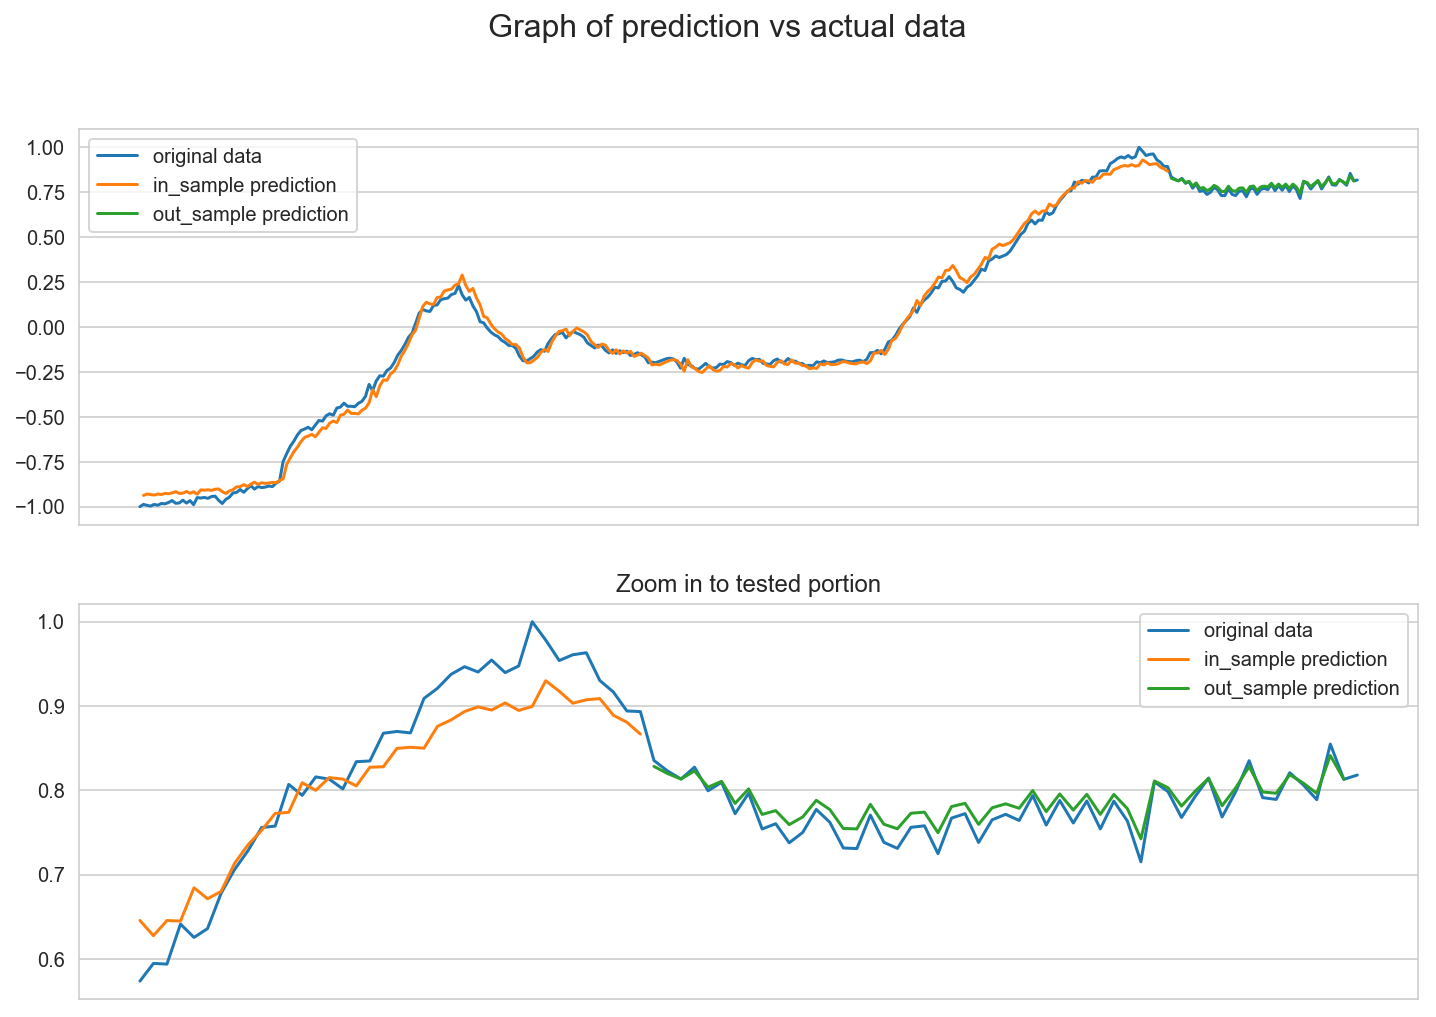

In [31]:
K.clear_session()

model = Sequential()
model.add(LSTM(4, input_shape=(None, lag)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
lstm_prediction_plotter(model,trainX,testX,mean_resale_px)
score = lstm_obtain_r2(model,trainX,testX,trainY,testY)
lstm_summary = add_lstm_score('mean_resale_px','1 layer| 4 nodes | optimizer = "adam"',score,[])

In [35]:
testX.shape

(52, 1, 1)

In [36]:
trainX.shape

(287, 1, 1)

In [37]:
52/287

0.18118466898954705

Epoch 1/20
287/287 [==============================] - 2s 6ms/step - loss: 0.1804
Epoch 2/20
287/287 [==============================] - 1s 3ms/step - loss: 0.0171
Epoch 3/20
287/287 [==============================] - 1s 3ms/step - loss: 6.1538e-04
Epoch 4/20
287/287 [==============================] - 1s 3ms/step - loss: 5.7467e-04
Epoch 5/20
287/287 [==============================] - 1s 3ms/step - loss: 5.6398e-04
Epoch 6/20
287/287 [==============================] - 1s 3ms/step - loss: 5.6133e-04
Epoch 7/20
287/287 [==============================] - 1s 3ms/step - loss: 5.8319e-04
Epoch 8/20
287/287 [==============================] - 1s 3ms/step - loss: 5.6461e-04
Epoch 9/20
287/287 [==============================] - 1s 3ms/step - loss: 5.7215e-04
Epoch 10/20
287/287 [==============================] - 1s 3ms/step - loss: 5.6152e-04
Epoch 11/20
287/287 [==============================] - 1s 3ms/step - loss: 5.9772e-04
Epoch 12/20
287/287 [==============================] - 1s 3ms/step - lo

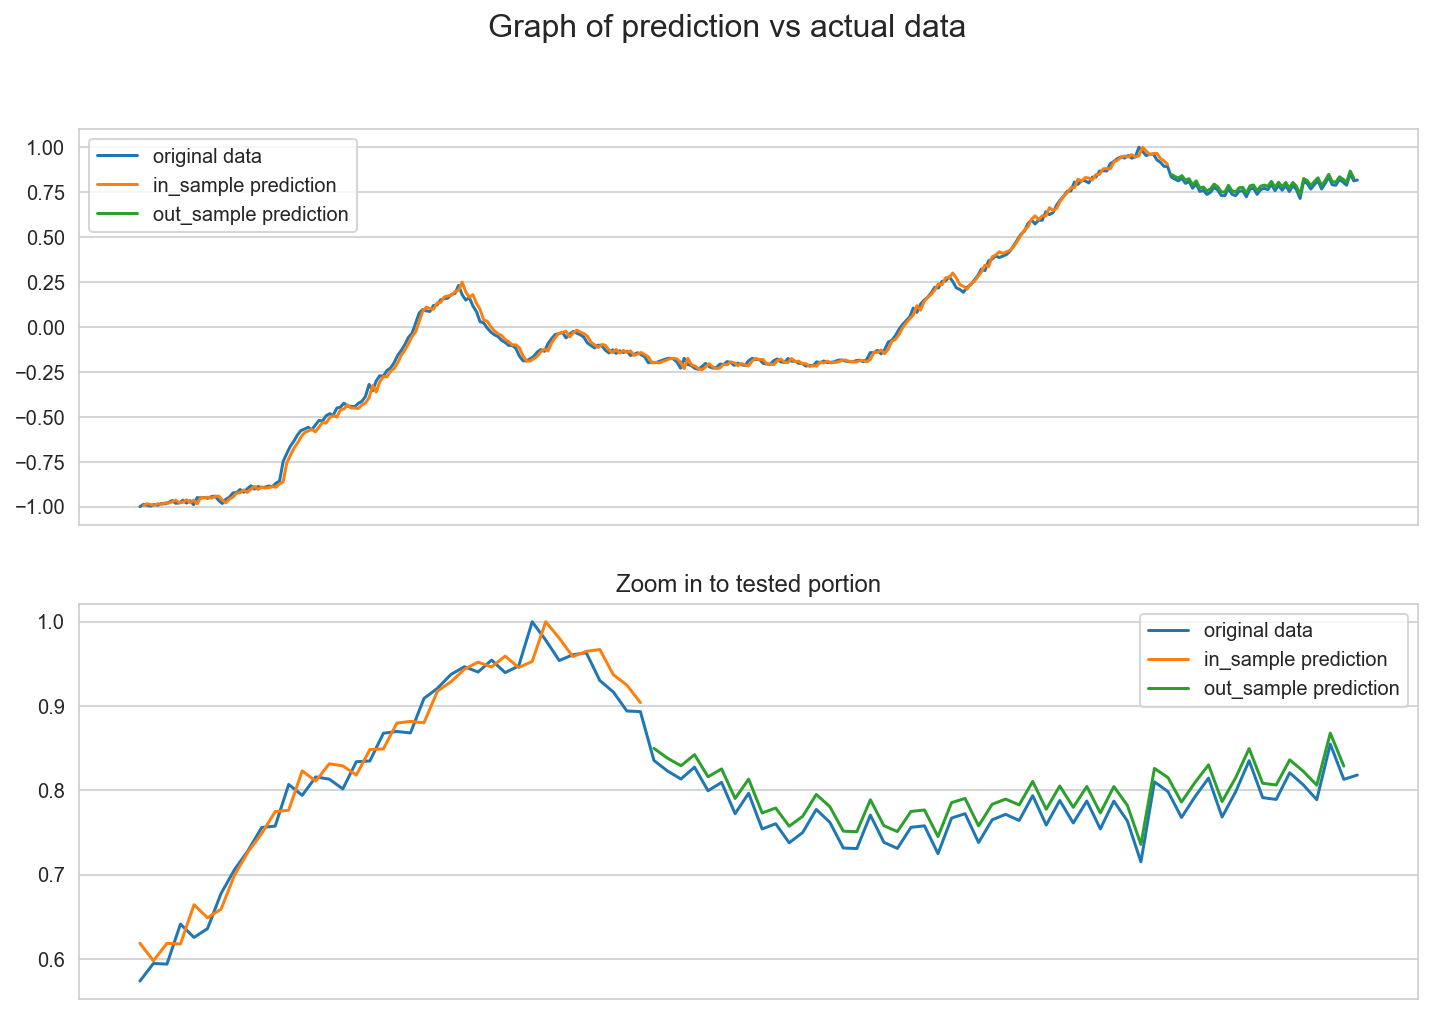

In [32]:
#optimiser = 'rmsprop'
K.clear_session()

model = Sequential()
model.add(LSTM(32, input_shape=(None, lag)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
lstm_prediction_plotter(model,trainX,testX,mean_resale_px)
score = lstm_obtain_r2(model,trainX,testX,trainY,testY)
lstm_summary = add_lstm_score('mean_resale_px','1 layer| 32 nodes | optimizer = "adam"',score,lstm_summary)

Epoch 1/20
287/287 [==============================] - 2s 6ms/step - loss: 0.1346
Epoch 2/20
287/287 [==============================] - 1s 3ms/step - loss: 0.0079
Epoch 3/20
287/287 [==============================] - 1s 3ms/step - loss: 6.1397e-04
Epoch 4/20
287/287 [==============================] - 1s 3ms/step - loss: 5.8138e-04
Epoch 5/20
287/287 [==============================] - 1s 3ms/step - loss: 5.7096e-04
Epoch 6/20
287/287 [==============================] - 1s 3ms/step - loss: 5.6621e-04
Epoch 7/20
287/287 [==============================] - 1s 3ms/step - loss: 5.6888e-04
Epoch 8/20
287/287 [==============================] - 1s 3ms/step - loss: 5.6616e-04
Epoch 9/20
287/287 [==============================] - 1s 3ms/step - loss: 5.5758e-04
Epoch 10/20
287/287 [==============================] - 1s 3ms/step - loss: 6.0274e-04
Epoch 11/20
287/287 [==============================] - 1s 3ms/step - loss: 5.8992e-04
Epoch 12/20
287/287 [==============================] - 1s 3ms/step - lo

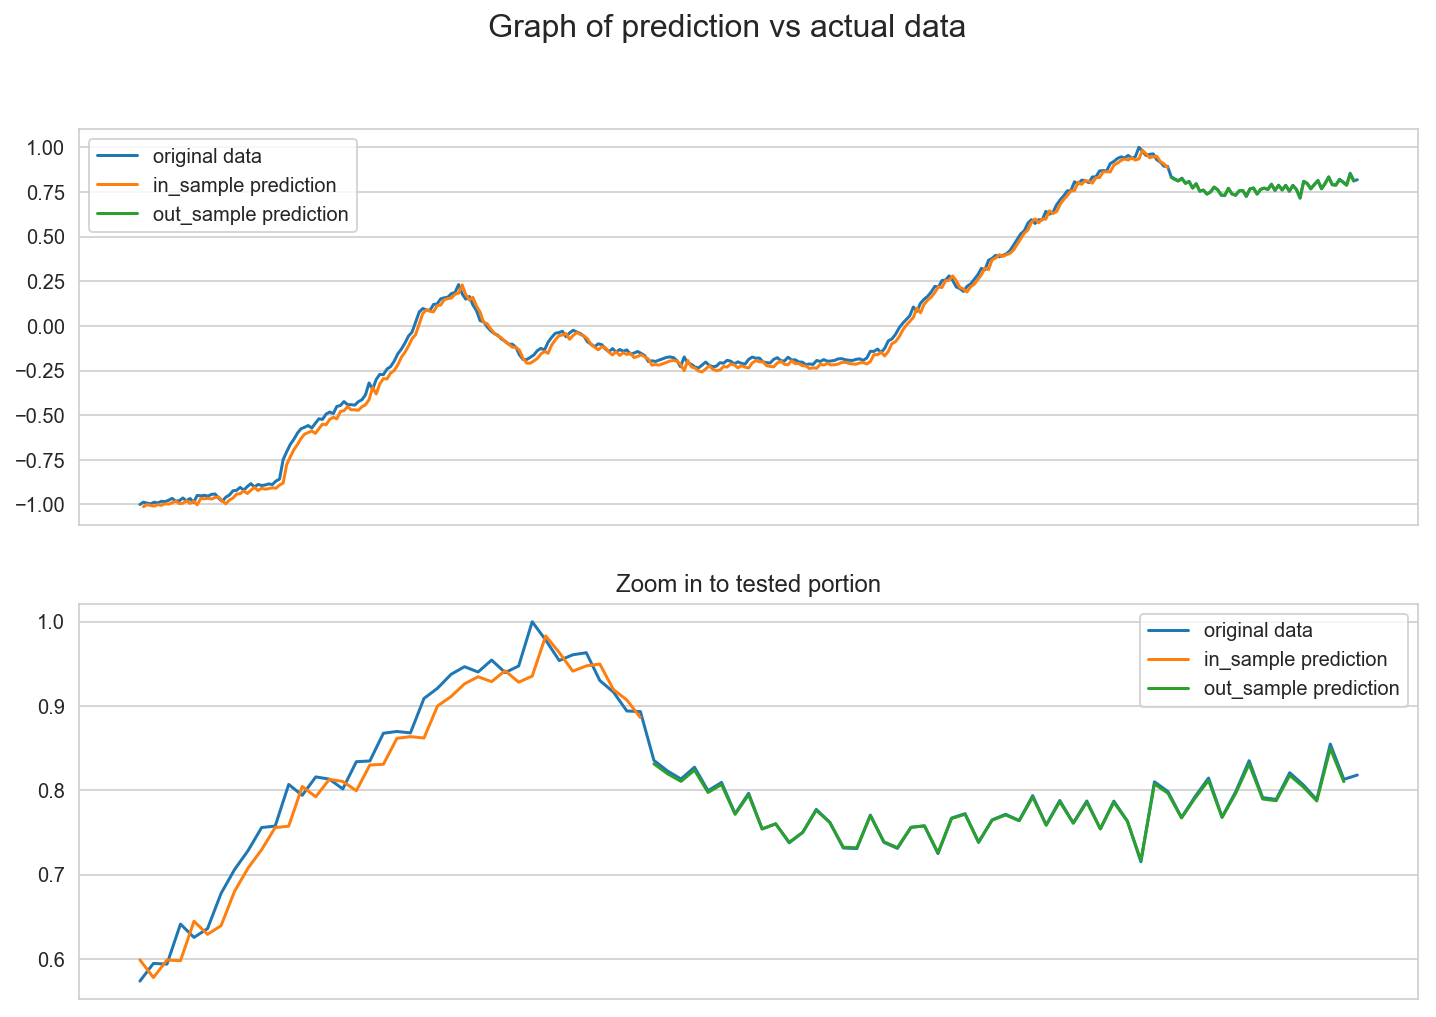

In [33]:
#optimiser = 'rmsprop'
K.clear_session()

model = Sequential()
model.add(LSTM(32, input_shape=(None, lag)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
lstm_prediction_plotter(model,trainX,testX,mean_resale_px)
score = lstm_obtain_r2(model,trainX,testX,trainY,testY)
lstm_summary = add_lstm_score('mean_resale_px','1 layer| 32 nodes | optimizer = "adam"',score,lstm_summary)

Epoch 1/10
287/287 [==============================] - 2s 6ms/step - loss: 0.1238
Epoch 2/10
287/287 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 3/10
287/287 [==============================] - 1s 2ms/step - loss: 5.9057e-04
Epoch 4/10
287/287 [==============================] - 1s 3ms/step - loss: 5.5373e-04
Epoch 5/10
287/287 [==============================] - 1s 2ms/step - loss: 5.4717e-04
Epoch 6/10
287/287 [==============================] - 1s 3ms/step - loss: 5.4383e-04
Epoch 7/10
287/287 [==============================] - 1s 2ms/step - loss: 5.4879e-04
Epoch 8/10
287/287 [==============================] - 1s 3ms/step - loss: 5.4521e-04
Epoch 9/10
287/287 [==============================] - 1s 3ms/step - loss: 5.4526e-04
Epoch 10/10
287/287 [==============================] - 1s 3ms/step - loss: 5.8382e-04
train_r2 0.9978550986521435
test_r2 0.9960753471622518


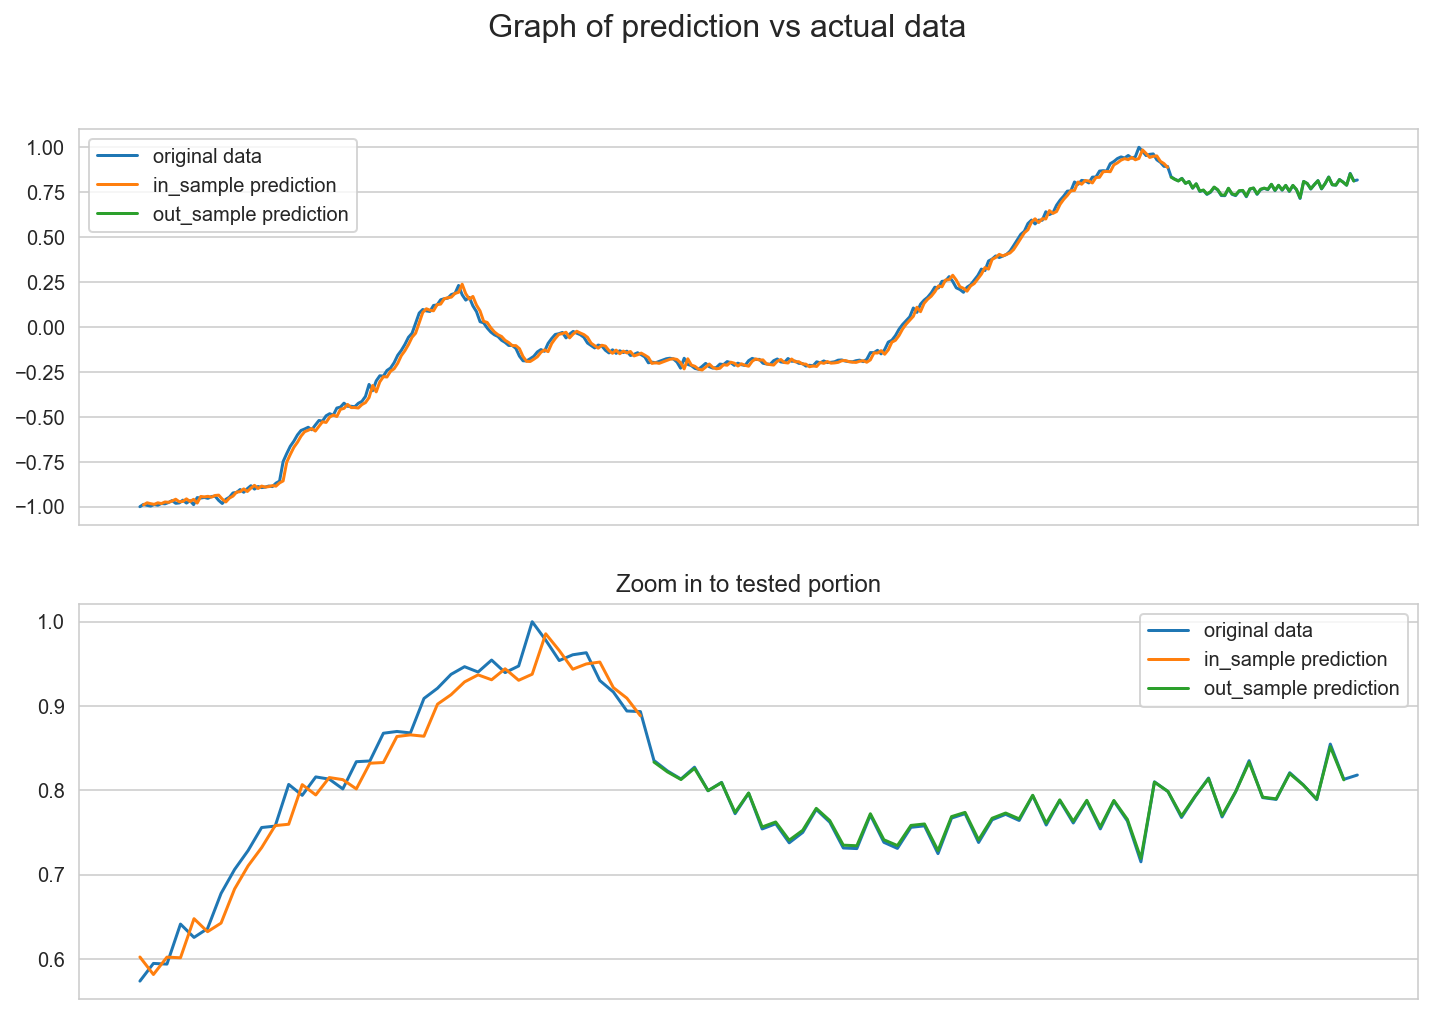

In [39]:
#optimiser = 'rmsprop'
K.clear_session()

model = Sequential()
model.add(LSTM(32, input_shape=(None, lag)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=1)
lstm_prediction_plotter(model,trainX,testX,mean_resale_px)
score = lstm_obtain_r2(model,trainX,testX,trainY,testY)
lstm_summary = add_lstm_score('mean_resale_px','1 layer| 32 nodes | optimizer = "adam"',score,lstm_summary)

In [41]:
model.reset_states()
trainPredict = model.predict(trainX)
model.reset_states()
testPredict = model.predict(testX)
model.reset_states()
train_r2 = r2_score(trainY[:-1], trainPredict[1:])
print('train_r2',train_r2) 
test_r2 = r2_score(testY[:-1], testPredict[1:])
print('test_r2',test_r2)

train_r2 0.9998878483580723
test_r2 0.9960753471622518


In [42]:
model.reset_states()
trainPredict = model.predict(trainX)
model.reset_states()
testPredict = model.predict(testX)
model.reset_states()

train_r2 = r2_score(trainY, trainPredict)
print('train_r2',train_r2) 
test_r2 = r2_score(testY, testPredict)
print('test_r2',test_r2)

train_r2 0.9978550986521435
test_r2 0.031705695684712376


In [44]:
mms.inverse_transform(testPredict)

array([[452253.4 ],
       [449777.03],
       [447869.16],
       [450665.84],
       [445087.28],
       [447071.72],
       [439630.72],
       [444498.75],
       [435983.25],
       [437233.44],
       [432668.47],
       [435156.22],
       [440648.66],
       [437597.22],
       [431425.5 ],
       [431280.84],
       [439300.72],
       [432779.47],
       [431323.66],
       [436374.9 ],
       [436736.72],
       [430066.03],
       [438580.25],
       [439639.9 ],
       [432743.84],
       [438169.2 ],
       [439478.94],
       [438014.97],
       [443927.2 ],
       [436926.75],
       [442777.16],
       [437412.47],
       [442661.88],
       [435996.97],
       [442628.84],
       [437882.6 ],
       [428099.56],
       [447204.22],
       [444892.22],
       [438726.8 ],
       [443677.34],
       [448100.72],
       [438843.06],
       [444822.75],
       [452193.28],
       [443457.28],
       [443031.  ],
       [449355.6 ],
       [446493.88],
       [442973.03],
